<h1><center> Predict Future Sales - Lightgbm hyperparameter Optuna </center></h1>

****

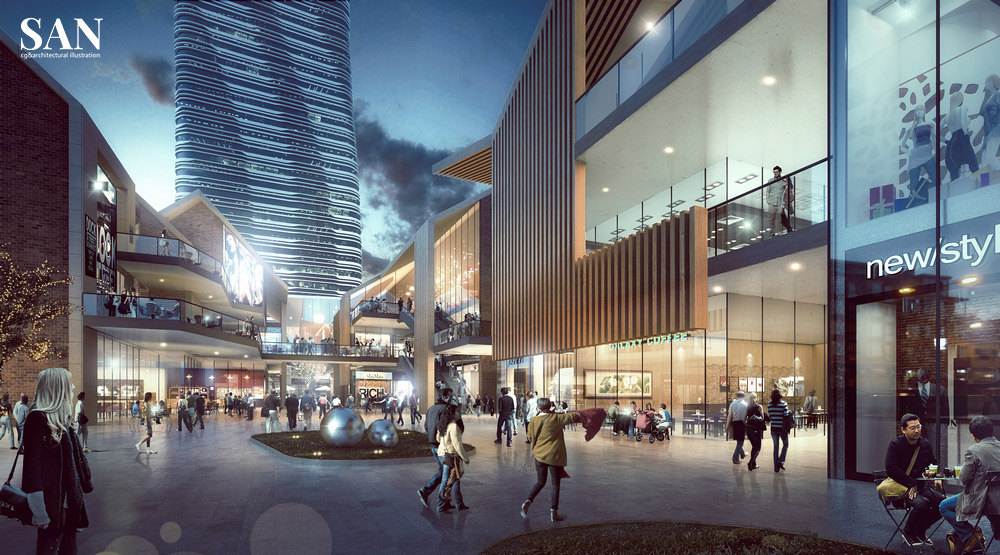

<h1> Introduction </h1>

****

In this competition, we have to predict the total sales for each product and store in the next month. To solved this problem, we are given daily historical sales data from several stores in 33 months ( January 2013 to October 2015 ).

****

Hello, this is my second notebook in this competition, if you want to see my other notebook, simple eda for this competition, its here [predict-future-sales-exploring-data](https://www.kaggle.com/dhiiyaur/predict-future-sales-exploring-data). The main idea of this notebook its to predict future sales with lgbm model and using optuna to find the best sets hyperparameters for model


### File descriptions

> * sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
> * test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
> * sample_submission.csv - a sample submission file in the correct format.
> * items.csv - supplemental information about the items/products.
> * item_categories.csv  - supplemental information about the items categories.
> * shops.csv- supplemental information about the shops.

### Data fields

> * ID - an Id that represents a (Shop, Item) tuple within the test set
> * shop_id - unique identifier of a shop
> * item_id - unique identifier of a product
> * item_category_id - unique identifier of item category
> * item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
> * item_price - current price of an item
> * date - date in format dd/mm/yyyy
> * date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
> * item_name - name of item
> * shop_name - name of shop
> * item_category_name - name of item category

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import gc
import pickle
import time
from itertools import product
import optuna
import lightgbm as lgb
from lightgbm import plot_importance
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
print('Done')

## Load Data

In [ ]:
# check data files

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
path = '../input/competitive-data-science-predict-future-sales/'

# train files
DF_sales       = pd.read_csv(path + 'sales_train.csv')
DF_items       = pd.read_csv(path + 'items.csv')
DF_item_cat    = pd.read_csv(path + 'item_categories.csv')
DF_shops       = pd.read_csv(path + 'shops.csv')

# test files
DF_test        = pd.read_csv(path + 'test.csv')
DF_sample_subs = pd.read_csv(path + 'sample_submission.csv')

Let's look at the train data file

In [ ]:
print(f'there are {DF_sales.shape[0]} rows and {DF_sales.shape[1]} columns')
DF_sales

In [ ]:
print(f'there are {DF_items.shape[0]} rows and {DF_items.shape[1]} columns')
DF_items.head(5)

In [ ]:
print(f'there are {DF_item_cat.shape[0]} rows and {DF_item_cat.shape[1]} columns')
DF_item_cat.head(5)

In [ ]:
print(f'there are {DF_shops.shape[0]} rows and {DF_shops.shape[1]} columns')
DF_shops.head(5)

Check missing values, and outliers from data

In [ ]:
print('---' * 10)
print('sales_train check\n')
print(DF_sales.isna().sum())
print('---' * 10)
print('item_cat check\n')
print(DF_items.isna().sum())
print('---' * 10)
print('item check\n')
print(DF_item_cat.isna().sum())
print('---' * 10)
print('shops check\n')
print(DF_shops.isna().sum())

Based on this data, it seems like there is no data missing

In [ ]:
DF_sales.describe()

there are outliers from data

In [ ]:
sns.boxplot( x= DF_sales.item_cnt_day )

In [ ]:
sns.boxplot( x= DF_sales.item_price )

In [ ]:
## Drop item_price and item_cnt_day too high
DF_sales = DF_sales[DF_sales.item_price<100000] # drop 1
DF_sales = DF_sales[DF_sales.item_cnt_day<1000] # drop 2

## Drop negative price 
DF_sales = DF_sales[DF_sales.item_price > 0].reset_index(drop=True) # drop 1

## The item has been returned 
DF_sales.loc[DF_sales.item_cnt_day < 0, 'item_cnt_day'] = 0

## Extract Information

in this section, I want to extract some information from data that will be useful in the prediction model
* Shops
* Items
* Time ( lag features, mean encoding )

## Shops

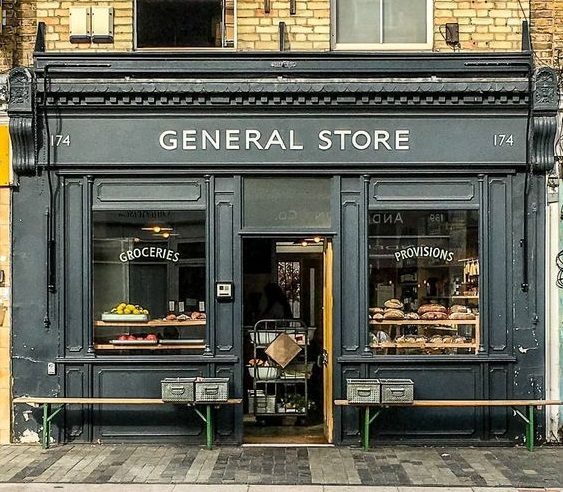

In [ ]:
DF_shops

Some shops have the same name (shops_id 0 - 57, 1 - 58, and 11 - 10), let's check again based on the opening and closing dates of the store, and check on the test data.

In [ ]:
print('shops_id 0 and 57\n')
print(f'Shop_id 0  : Date = {DF_sales[DF_sales.shop_id == 0].date.min()} - {DF_sales[DF_sales.shop_id == 0].date.max()}')
print(f'Shop_id 57 : Date = {DF_sales[DF_sales.shop_id == 57].date.min()} - {DF_sales[DF_sales.shop_id == 57].date.max()}')

print('----'*10)

print('shops_id 1 and 58\n')
print(f'Shop_id 1  : Date = {DF_sales[DF_sales.shop_id == 1].date.min()} - {DF_sales[DF_sales.shop_id == 1].date.max()}')
print(f'Shop_id 58 : Date = {DF_sales[DF_sales.shop_id == 58].date.min()} - {DF_sales[DF_sales.shop_id == 58].date.max()}')

print('----'*10)

print('shops_id 10 and 11\n')
print(f'Shop_id 10  : Date = {DF_sales[DF_sales.shop_id == 10].date.min()} - {DF_sales[DF_sales.shop_id == 10].date.max()}')
print(f'Shop_id 11  : Date = {DF_sales[DF_sales.shop_id == 11].date.min()} - {DF_sales[DF_sales.shop_id == 11].date.max()}')

The store names are the same, but they don't open and close at the same time, let's check if store_id is in the test data.

In [ ]:
a = DF_sales.shop_id.unique()
b = DF_test.shop_id.unique()
print(f'shop_id which only exists in one of the data ( train or test )\n{set(a) - set(b)}')

shops_id 0, 1, and 11 are not in the test data, I think we should merge the shop id to solve that problem

In [ ]:
# Якутск Орджоникидзе, 56
DF_sales.loc[DF_sales.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
DF_sales.loc[DF_sales.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
DF_sales.loc[DF_sales.shop_id == 11, 'shop_id'] = 10

In [ ]:
# extract city and category location from shop name

DF_shops.loc[DF_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'  # fix name
DF_shops['shop_city'] = DF_shops['shop_name'].str.split(' ').map(lambda x: x[0])
DF_shops['shop_cat'] = DF_shops['shop_name'].str.split(' ').map(lambda x: x[1])
DF_shops.head(5)

In [ ]:
# label encoder for shops

DF_shops['shop_city']  = LabelEncoder().fit_transform(DF_shops['shop_city'] )
DF_shops['shop_cat'] = LabelEncoder().fit_transform(DF_shops['shop_cat'])
DF_shops.drop(['shop_name'], axis=1, inplace= True)
DF_shops.head(5)

## Items

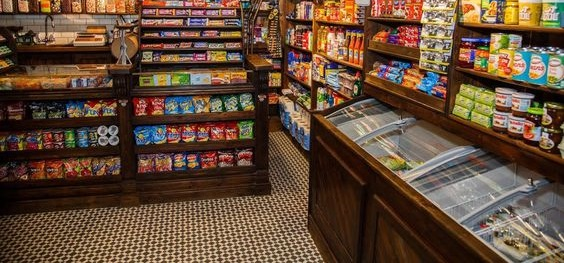

In [ ]:
# merge item data and item category data

DF_items = pd.merge(DF_items, DF_item_cat, on = 'item_category_id')
DF_items

In [ ]:
# split item categories into several parts

DF_items['item_sub_cat_1'] = np.select(
    [DF_items.item_category_id.isin(range(0,8)),
    DF_items.item_category_id.isin(range(10,18)),
    DF_items.item_category_id.isin(range(18,32)),
    DF_items.item_category_id.isin(range(32,37)),
    DF_items.item_category_id.isin(range(37,42)),
    DF_items.item_category_id.isin(range(42,55)),
    DF_items.item_category_id.isin(range(55,61)),
    DF_items.item_category_id.isin(range(61,73)),
    DF_items.item_category_id.isin(range(73,79)),
    DF_items.item_category_id.isin([8,80]),
    DF_items.item_category_id==83, 
    DF_items.item_category_id==9,
    DF_items.item_category_id==79,  
    DF_items.item_category_id.isin([81,82])],

    ['accessories','consoles','games','payment_cards','Cinema','books','music',
     'gifts','programs','tickets','batteries','delivery','office','discs'])

DF_items

In [ ]:
# label encoder for item_category and drop some colomns

DF_items['item_sub_cat_1'] = LabelEncoder().fit_transform(DF_items['item_sub_cat_1'])
DF_items.drop(['item_name','item_category_name'], axis=1, inplace= True)
DF_items

## Time

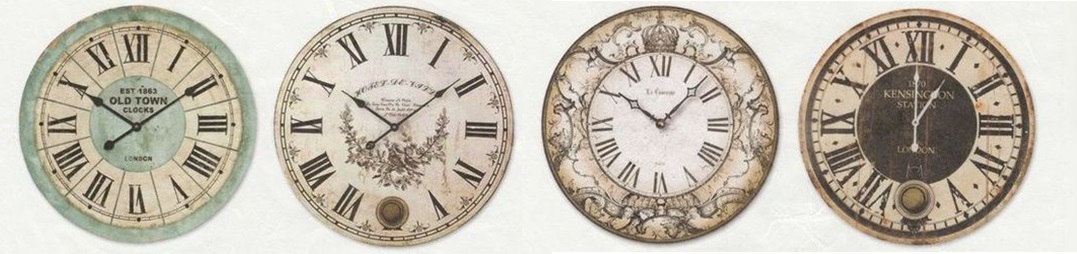

In [ ]:
# prepare train data

DF_all = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = DF_sales[DF_sales.date_block_num==i]
    DF_all.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
DF_all = pd.DataFrame(np.vstack(DF_all), columns=cols)
DF_all['date_block_num'] = DF_all['date_block_num'].astype(np.int8)
DF_all['shop_id'] = DF_all['shop_id'].astype(np.int8)
DF_all['item_id'] = DF_all['item_id'].astype(np.int16)
DF_all.sort_values(cols,inplace=True)
DF_all

In [ ]:
# prepare test data

DF_test.drop(['ID'], axis=1, inplace = True)
DF_test['date_block_num'] = 34
DF_test['date_block_num'] = DF_test['date_block_num']
DF_test['shop_id'] = DF_test['shop_id']
DF_test['item_id'] = DF_test['item_id']
DF_test.head()

In [ ]:
# merger into data into one dataframe

DF_all = pd.concat([DF_all, DF_test], ignore_index=True, sort=False, keys=cols)
DF_all = pd.merge(DF_all, DF_shops, on=['shop_id'], how='left')
DF_all = pd.merge(DF_all, DF_items, on=['item_id'], how='left')
DF_all.fillna(0, inplace=True)
DF_all

In [ ]:
# change type column to reduce memory use 

DF_all.date_block_num    = DF_all.date_block_num.astype(np.int8)
DF_all.shop_id           = DF_all.shop_id.astype(np.int8)
DF_all.item_id           = DF_all.item_id.astype(np.int16)
DF_all.shop_city         = DF_all.shop_city.astype(np.int8)
DF_all.shop_cat          = DF_all.shop_cat.astype(np.int8)
DF_all.item_category_id  = DF_all.item_category_id.astype(np.int8)
DF_all.item_sub_cat_1    = DF_all.item_sub_cat_1.astype(np.int8)

### Create Lag Features and Mean-Encodings

* item_cnt_month
* Monthly - item_cnt_month 
* Monthly item - item_cnt_month
* Monthly shops - item_cnt_month
* Monthly item_category - item_cnt_month
* Monthly shops item_category - item_cnt_month
* Monthly shops item - item_cnt_month
* Monthly shops subs_item category - item_cnt_month
* Monthly shops_city - item_cnt_month

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def fill_na_test(df):
    for col in df.columns:
        if ('_lag' in col) & (df[col].isnull().any()):
            print(col)
            if ('month' in col):
                df[col].fillna(0, inplace=True)         
    return df

Aggregating item_cnt_month to a monthly level and clip variable, because target values are clipped into [0,20] range.

In [ ]:
temp = DF_sales.groupby(['shop_id','item_id','date_block_num']).agg(item_cnt_month=('item_cnt_day',sum))
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=cols, how='left')
DF_all['item_cnt_month'] = (DF_all['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [ ]:
ts = time.time()

# item_cnt_month

DF_all = lag_feature(DF_all, [1, 2, 3], 'item_cnt_month')


# Monthly - item_cnt_month

temp = DF_all.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num'], how='left')
DF_all = lag_feature(DF_all, [1, 2, 3], 'avg_month')
DF_all.drop(['avg_month'], axis=1, inplace= True)

# Monthly item - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'item_id'], how='left')
DF_all = lag_feature(DF_all, [1, 2, 3], 'avg_item_month')
DF_all.drop(['avg_item_month'], axis=1, inplace= True)

# Monthly shops - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shop_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'shop_id'], how='left')
DF_all = lag_feature(DF_all, [1, 2, 3], 'avg_shop_month')
DF_all.drop(['avg_shop_month'], axis=1, inplace= True)

# Monthly item_category - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_cat_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'item_category_id'], how='left')
DF_all = lag_feature(DF_all, [1,2], 'avg_item_cat_month')
DF_all.drop(['avg_item_cat_month'], axis=1, inplace= True)

# Monthly shops item_category - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_itemcat_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
DF_all = lag_feature(DF_all, [1,2], 'avg_shops_itemcat_month')
DF_all.drop(['avg_shops_itemcat_month'], axis=1, inplace= True)

# Monthly shops item - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
DF_all = lag_feature(DF_all, [1,2], 'avg_shops_item_month')
DF_all.drop(['avg_shops_item_month'], axis=1, inplace= True)

# Monthly shops subs_item category - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'shop_id', 'item_sub_cat_1']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_sub_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'shop_id', 'item_sub_cat_1'], how='left')
DF_all = lag_feature(DF_all, [1,2], 'avg_shops_item_sub_month')
DF_all.drop(['avg_shops_item_sub_month'], axis=1, inplace= True)

# Monthly shops_city - item_cnt_month

temp = DF_all.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shopscity_month']
temp.reset_index(inplace=True)
DF_all = pd.merge(DF_all, temp, on=['date_block_num', 'shop_city'], how='left')
DF_all = lag_feature(DF_all, [1,2], 'avg_shopscity_month')
DF_all.drop(['avg_shopscity_month'], axis=1, inplace= True)

DF_all

print('Use time:', time.time() - ts)


### Additional features

* days, month, and year features
* The first month when one item is on sale

In [ ]:
# days, month, and year features

DF_all['month'] = DF_all['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
DF_all['days'] = DF_all['month'].map(days)
DF_all['years'] = np.select(
    [DF_all.date_block_num.isin(range(0,12)),
     DF_all.date_block_num.isin(range(12,25)),
     DF_all.date_block_num.isin(range(25,35))],
    ['13','14','15'])

DF_all['month'] = DF_all['month'] + 1  # fix month

# change type column to reduce memory use

DF_all['days'] = DF_all['days'].astype(np.int8)
DF_all['month'] = DF_all['month'].astype(np.int8)
DF_all['years'] = DF_all['years'].astype(np.int8)
DF_all

In [ ]:
# The first month when one item is on sale

DF_all['item_shop_first_sale'] = \
DF_all['date_block_num'] - DF_all.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

DF_all['item_first_sale'] = \
DF_all['date_block_num'] - DF_all.groupby('item_id')['date_block_num'].transform('min')
DF_all

****

### Prepare data for model

In [ ]:
# check null data 
DF_all.isnull().any()

In [ ]:
# fill null data with zero (0)
DF_all = fill_na_test(DF_all)
DF_all.isnull().any()

In [ ]:
DF_all.info()

In [ ]:
DF_all.to_pickle('dataset.pkl')

In [ ]:
del DF_all
del temp
del DF_sales
del DF_items
del DF_item_cat
del DF_shops
gc.collect()

****

## Create a model

In [ ]:
# read pickle data 

data = pd.read_pickle('dataset.pkl')

In [ ]:
data.columns

In [ ]:
data = data[[
       
       'date_block_num', 'shop_id', 'item_id', 'shop_city', 'shop_cat',
       'item_category_id', 'item_sub_cat_1', 'item_cnt_month',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'avg_month_lag_1', 'avg_month_lag_2', 'avg_month_lag_3',
       'avg_item_month_lag_1', 'avg_item_month_lag_2', 'avg_item_month_lag_3',
       'avg_shop_month_lag_1', 'avg_shop_month_lag_2', 'avg_shop_month_lag_3',
       'avg_item_cat_month_lag_1', 'avg_item_cat_month_lag_2',
       'avg_shops_itemcat_month_lag_1', 'avg_shops_itemcat_month_lag_2',
       'avg_shops_item_month_lag_1', 'avg_shops_item_month_lag_2',
       'avg_shops_item_sub_month_lag_1', 'avg_shops_item_sub_month_lag_2',
       'avg_shopscity_month_lag_1', 'avg_shopscity_month_lag_2', 'month',
       'days', 'years', 'item_shop_first_sale', 'item_first_sale'
]]

In [ ]:
data

In [ ]:
# create train and validation data

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test  = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

## Optuna hyperparameters

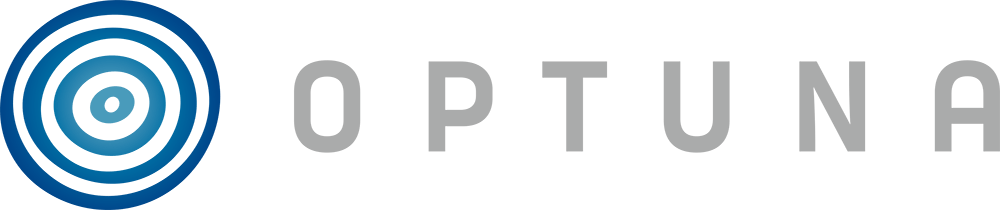

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. with optuna, we can choose whatever parameters that we want to optimization

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


In [ ]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

In [ ]:
def objective(trial):
    
    # choose parameters that you want
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=15, #10,
                      verbose_eval=1)
    
    y_pred = model.predict(X_valid)
    accuracy = rmsle(Y_valid, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
best_params = study.best_trial.params
print(f'Best trial parameters\n{best_params}')

In [ ]:
# add some fix params

x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

best_params.update(x)
best_params

In [ ]:
evals_result = {} 

model = lgb.train(best_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],
                  evals_result=evals_result,
                  early_stopping_rounds=30, # 20
                  verbose_eval=1,
                  )

In [ ]:
y_pred = model.predict(X_valid)
rmsle(Y_valid, y_pred)

In [ ]:
print('feature importans')
plot_features(model, (10,14))

In [ ]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, figsize=(10, 5))

In [ ]:
# predicting model

Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": DF_test.index, 
    "item_cnt_month": Y_test
})
submission.head(10)

In [ ]:
submission.to_csv('submission.csv', index=False)

****

<h1><center>Thank you for reading my notebook, upvote if you like this notebook :)</center></h1>


***

# References

* https://github.com/Microsoft/LightGBM
* https://github.com/optuna/optuna
* https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization
* https://www.kaggle.com/dlarionov/feature-engineering-xgboost
* https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
